In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pywt

import torch

In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/F.D./data/train_data.csv')
df.set_index('timestamp', inplace=True)

### Wavelet Decomposed Cryptocurrency data

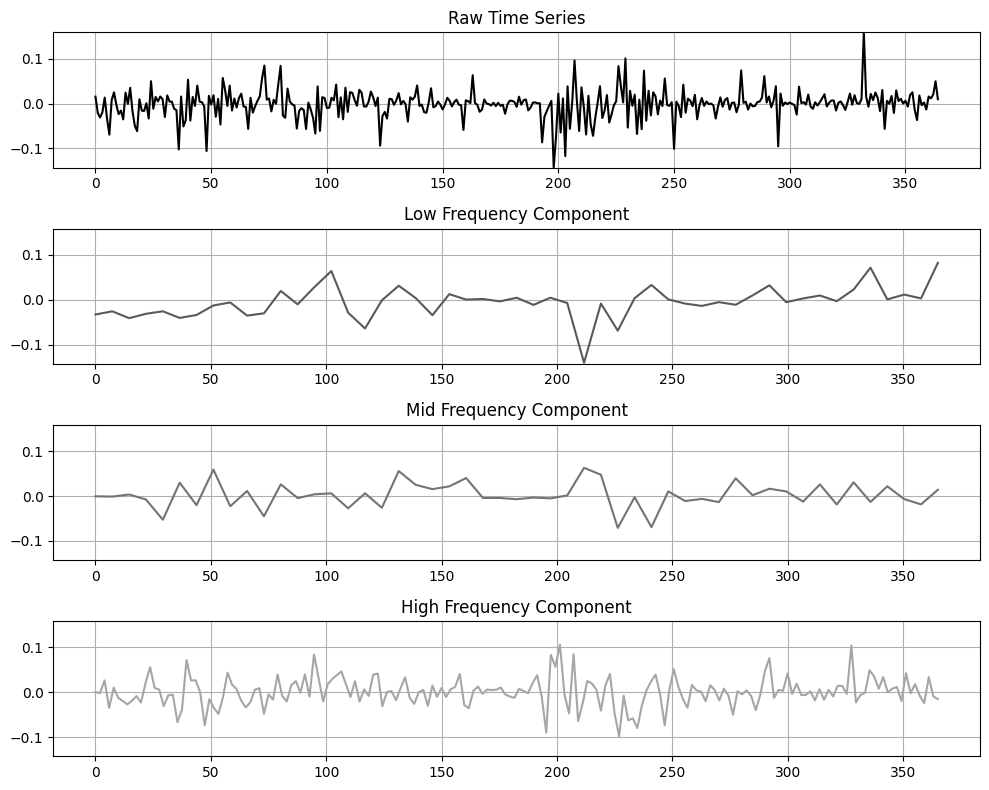

In [ ]:
data = df.values
btc_data = data[:, 0]   # sample
window_size = 365       # 2018.05.05 - 2019.05.04
window_data = btc_data[:window_size]

wavelet='db4'
level=3

coeffs = pywt.wavedec(window_data, wavelet, level=level)
cA3, cD3, _, cD1 = coeffs

times_raw = np.arange(len(window_data))
times_cA3 = np.linspace(0, len(window_data), len(cA3))
times_cD3 = np.linspace(0, len(window_data), len(cD3))
times_cD1 = np.linspace(0, len(window_data), len(cD1))

all_vals = np.concatenate([window_data, cA3, cD3, cD1])
y_min, y_max = all_vals.min(), all_vals.max()

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharey=True)

axs[0].plot(times_raw, window_data, color='black')
axs[0].set_title('Raw Time Series')
axs[0].grid()

axs[1].plot(times_cA3, cA3, color='0.35')
axs[1].set_title('Low Frequency Component')
axs[1].grid()

axs[2].plot(times_cD3, cD3, color='0.45')
axs[2].set_title('Mid Frequency Component')
axs[2].grid()

axs[3].plot(times_cD1, cD1, color='0.65')
axs[3].set_title('High Frequency Component')
axs[3].grid()

# 동일한 y축 범위 설정
for ax in axs:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/F.D./figure/Wavelet.png')
plt.show()

### Evaluation

In [ ]:
model_save_path = '/content/drive/MyDrive/F.D./best_model'

WCT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WCT_result.pt", map_location=torch.device('cpu'))
WC_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WC_result.pt", map_location=torch.device('cpu'))
WT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_WT_result.pt", map_location=torch.device('cpu'))
CT_loaded = torch.load(f"{model_save_path}/best_model_window10per30_CT_result.pt", map_location=torch.device('cpu'))

In [ ]:
for title, model in zip(['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer'], [WCT_loaded, WC_loaded, WT_loaded, CT_loaded]):

    preds_tensor = model['preds']
    targets_tensor = model['targets']

    preds_flat = preds_tensor.view(preds_tensor.size(0), -1).cpu().numpy()
    targets_flat = targets_tensor.view(targets_tensor.size(0), -1).cpu().numpy()

    mse = mean_squared_error(targets_flat, preds_flat)
    mae = mean_absolute_error(targets_flat, preds_flat)
    rmse = np.sqrt(mse)

    # frobenius_loss
    cos_sim = cosine_similarity(targets_flat, preds_flat)
    mean_cos_sim = np.diag(cos_sim).mean()

    # frobenius_loss
    diff = preds_tensor - targets_tensor
    frobenius_per_sample = torch.norm(diff, p='fro', dim=(1, 2))
    mean_frobenius = frobenius_per_sample.mean().item()

    print(f"{title} Evaluation Results:")
    print(f"MSE               : {mse:.5f}")
    print(f"MAE               : {mae:.5f}")
    print(f"RMSE              : {rmse:.5f}")
    print(f"Cosine Similarity : {mean_cos_sim:.5f}")
    print(f"Frobenius Norm    : {mean_frobenius:.5f}")

    T, M, N = preds_tensor.shape

    mse_list = []
    mae_list = []
    rmse_list = []
    cos_sim_list = []
    frobenius_list = []

    for t in range(T):
        y_true = targets_tensor[t]  # (M, N)
        y_pred = preds_tensor[t]    # (M, N)

        # Flatten for sklearn
        y_true_flat = y_true.view(-1).cpu().numpy()
        y_pred_flat = y_pred.view(-1).cpu().numpy()

        # MSE, MAE, RMSE
        mse = mean_squared_error(y_true_flat, y_pred_flat)
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)

        # Cosine similarity (1 sample, 1 sample)
        cos_sim = cosine_similarity([y_true_flat], [y_pred_flat])[0, 0]

        # Frobenius norm
        frob = torch.norm(y_pred - y_true, p='fro').item()

        # 저장
        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        cos_sim_list.append(cos_sim)
        frobenius_list.append(frob)

    # 시각화
    time_steps = list(range(T))
    plt.figure(figsize=(50, 20))

    plt.plot(time_steps, mse_list, label="MSE", color='red', linewidth=5)
    plt.plot(time_steps, mae_list, label="MAE", color='blue', linewidth=5)
    plt.plot(time_steps, rmse_list, label="RMSE", color='green', linewidth=5)
    plt.plot(time_steps, cos_sim_list, label="Cosine Similarity", color='orange', linewidth=5)
    plt.plot(time_steps, frobenius_list, label="Frobenius Norm", color='purple', linewidth=5)


    plt.xlabel("Date", fontsize=50)
    plt.xticks(fontsize=35)

    plt.ylabel("Score Range", fontsize=50)
    plt.yticks(fontsize=35)

    plt.title(f"{title} Time-Varying Performance Scores", fontsize=70)
    plt.legend(fontsize=40)
    plt.grid(True)

    plt.savefig(f'/content/drive/MyDrive/F.D./figure/{title}_performance_scores.png')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 모든 모델의 모든 지표 값들을 모아서 min/max 계산
all_scores = []

for title, model in zip(
    ['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer'],
    [WCT_loaded, WC_loaded, WT_loaded, CT_loaded]
):
    preds_tensor = model['preds']
    targets_tensor = model['targets']

    T, M, N = preds_tensor.shape

    for t in range(T):
        y_true_flat = targets_tensor[t].view(-1).cpu().numpy()
        y_pred_flat = preds_tensor[t].view(-1).cpu().numpy()

        mse = mean_squared_error(y_true_flat, y_pred_flat)
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)
        cos_sim = cosine_similarity([y_true_flat], [y_pred_flat])[0, 0]
        frob = torch.norm(preds_tensor[t] - targets_tensor[t], p='fro').item()

        all_scores.extend([mse, mae, rmse, cos_sim, frob])

# y축 범위 설정
y_min = min(all_scores)
y_max = max(all_scores)

# ===== 기존 플롯 루프 =====
for title, model in zip(
    ['WCT', 'Wavelet Decomposed CNN', 'Wavelet Decomposed Transformer', 'CNN Transformer'],
    [WCT_loaded, WC_loaded, WT_loaded, CT_loaded]
):
    preds_tensor = model['preds']
    targets_tensor = model['targets']
    T, M, N = preds_tensor.shape

    mse_list, mae_list, rmse_list, cos_sim_list, frobenius_list = [], [], [], [], []

    for t in range(T):
        y_true_flat = targets_tensor[t].view(-1).cpu().numpy()
        y_pred_flat = preds_tensor[t].view(-1).cpu().numpy()

        mse = mean_squared_error(y_true_flat, y_pred_flat)
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        rmse = np.sqrt(mse)
        cos_sim = cosine_similarity([y_true_flat], [y_pred_flat])[0, 0]
        frob = torch.norm(preds_tensor[t] - targets_tensor[t], p='fro').item()

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        cos_sim_list.append(cos_sim)
        frobenius_list.append(frob)

    time_steps = list(range(T))
    plt.figure(figsize=(50, 20))

    plt.plot(time_steps, mse_list, label="MSE", color='red', linewidth=5)
    plt.plot(time_steps, mae_list, label="MAE", color='blue', linewidth=5)
    plt.plot(time_steps, rmse_list, label="RMSE", color='green', linewidth=5)
    plt.plot(time_steps, cos_sim_list, label="Cosine Similarity", color='orange', linewidth=5)
    plt.plot(time_steps, frobenius_list, label="Frobenius Norm", color='purple', linewidth=5)

    plt.ylim(y_min, y_max)  # 동일 y축 범위 적용

    plt.xlabel("Date", fontsize=50)
    plt.xticks(fontsize=35)

    plt.ylabel("Score Range", fontsize=50)
    plt.yticks(fontsize=35)

    plt.title(f"{title} Time-Varying Performance Scores", fontsize=70)
    plt.legend(fontsize=40)
    plt.grid(True)

    plt.savefig(f'/content/drive/MyDrive/F.D./figure/{title}_performance_scores.png')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

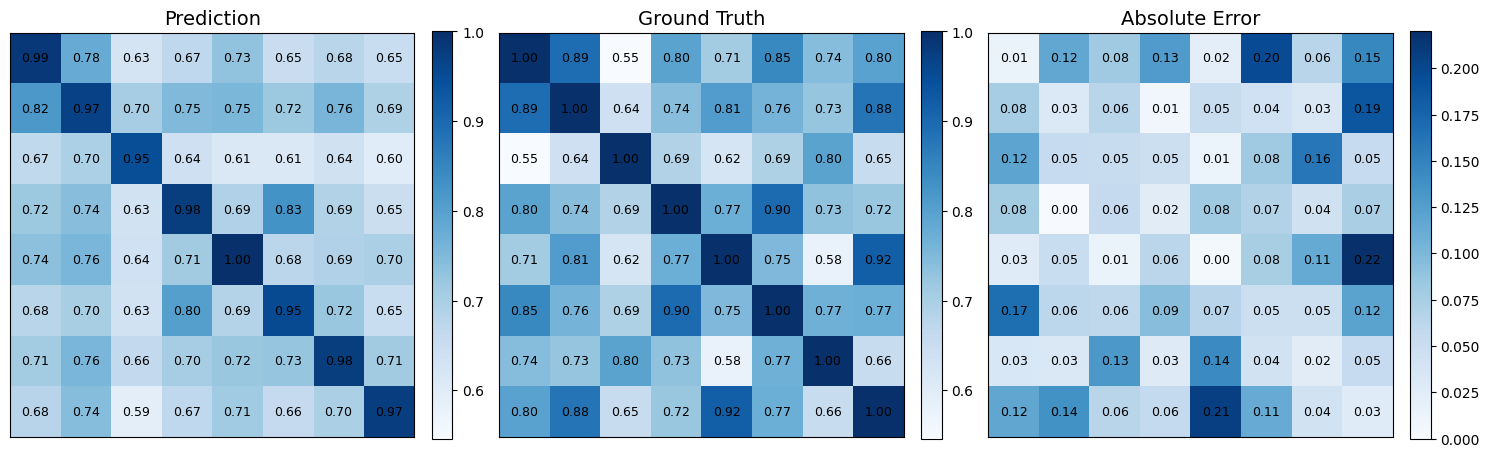

In [ ]:
preds_tensor = WCT_loaded['preds']
targets_tensor = WCT_loaded['targets']

idx = 3
pred_mat = preds_tensor[idx].cpu().numpy()
true_mat = targets_tensor[idx].cpu().numpy()
error_mat = np.abs(pred_mat - true_mat)

common_min = min(pred_mat.min(), true_mat.min())
common_max = max(pred_mat.max(), true_mat.max())
error_max = error_mat.max()

titles = ["Prediction", "Ground Truth", "Absolute Error"]
matrices = [pred_mat, true_mat, error_mat]
cmap = "Blues"
vmins = [common_min, common_min, 0]
vmaxs = [common_max, common_max, error_max]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, title, vmin, vmax in zip(axes, matrices, titles, vmins, vmaxs):
    im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=14)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center",
                    color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/F.D./figure/sample_visualization.png')
plt.show()